In [166]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from math import ceil
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.model_selection import KFold


# LOAD AND PREPARE DATA

Test Dataset 1

In [167]:
# Load and clean data
data = pd.read_csv("traffic_crashes_people.csv")
data = data.drop(['physical_condition', 'airbag_deployed', 'ejection'], axis=1)
# Random sample 8,000 rows using seed 1337
data = data.dropna().reset_index(drop=True)
data = data.sample(n=25000, random_state=1337)
target = 'injury_classification'
data.head()

,person_type,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,driver_vision,injury_classification
48818,DRIVER,CHICAGO,IL,60638,F,69.0,IL,D,SAFETY BELT USED,NOT OBSCURED,NO INDICATION OF INJURY
92569,DRIVER,CHICAGO,IL,60621,F,23.0,IL,D,USAGE UNKNOWN,UNKNOWN,NO INDICATION OF INJURY
15025,DRIVER,CHICAGO,IL,60647,M,43.0,IL,D,USAGE UNKNOWN,UNKNOWN,NO INDICATION OF INJURY
72716,DRIVER,CHICAGO,IL,60629,F,30.0,IL,D,SAFETY BELT USED,NOT OBSCURED,NO INDICATION OF INJURY
13212,DRIVER,CHICAGO,IL,60653,M,41.0,IL,D,SAFETY BELT NOT USED,NOT OBSCURED,NO INDICATION OF INJURY


Test Dataset 2

In [168]:
# # Cleanning Method 2 ================================
# data = pd.read_table('fruit_data_with_colors.txt')
# data = data.dropna().drop(columns=['fruit_subtype', 'fruit_label'])
# target = "fruit_name"
# data.head()


# PROCESS DATA

Check Numerical and Categorical Columns

In [169]:
data.columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns
num_cols = data.select_dtypes(exclude=['object', 'category']).columns

print("Numeric columns:", num_cols.tolist())
print("Categorical columns:", cat_cols.tolist())

Numeric columns: ['age']
Categorical columns: ['person_type', 'city', 'state', 'zipcode', 'sex', 'drivers_license_state', 'drivers_license_class', 'safety_equipment', 'driver_vision', 'injury_classification']


One Hot Encoding

In [170]:
X = data.drop(columns=[target])
y = data[target]

# Separate categorical and numeric columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Only build encoder if categorical columns exist
if len(cat_cols) > 0:
    ohe = OneHotEncoder(
        handle_unknown='infrequent_if_exist',
        min_frequency=0.01,   # ~1% threshold for infrequent categories
        sparse_output=False,
        dtype=int              # ensures 0/1 not True/False
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', ohe, cat_cols),
            ('num', 'passthrough', num_cols)
        ],
        remainder='drop'
    )

    # ⚠️ Use fit_transform only the first time
    X_encoded = preprocessor.fit_transform(X)
    feature_names = preprocessor.get_feature_names_out()
else:
    X_encoded = X.values
    feature_names = X.columns

data2 = pd.DataFrame(X_encoded, columns=feature_names)

# Attach target
data2 = pd.concat([data2, y.reset_index(drop=True)], axis=1)
data2.head()

,cat__person_type_DRIVER,cat__person_type_infrequent_sklearn,cat__city_CHICAGO,cat__city_CICERO,cat__city_infrequent_sklearn,cat__state_IL,cat__state_infrequent_sklearn,cat__zipcode_60608,cat__zipcode_60609,cat__zipcode_60612,...,cat__safety_equipment_NONE PRESENT,cat__safety_equipment_SAFETY BELT USED,cat__safety_equipment_USAGE UNKNOWN,cat__safety_equipment_infrequent_sklearn,cat__driver_vision_NOT OBSCURED,cat__driver_vision_OTHER,cat__driver_vision_UNKNOWN,cat__driver_vision_infrequent_sklearn,num__age,injury_classification
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,69.0,NO INDICATION OF INJURY
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,NO INDICATION OF INJURY
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,43.0,NO INDICATION OF INJURY
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,30.0,NO INDICATION OF INJURY
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,41.0,NO INDICATION OF INJURY


# SPLIT TRAIN, VAIDATION, TEST

### SELECT TEST DATA

METHOD 1  
Last rows as test data. Best for Time Series

In [171]:
# Separate features and target
X = data2.drop(columns=[target])
y = data2[target]
num_latest_data = int(len(X)*0.05)
# Final test: last 1000 rows (keep deterministic)
X_test = X.tail(num_latest_data)
y_test = y.tail(num_latest_data)

# Remaining data
X_train_val = X.iloc[:-num_latest_data]
y_train_val = y.iloc[:-num_latest_data]

print(f"Train and Val size: {len(X_train_val)} rows ({len(X_train_val)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_test)} rows ({len(X_test)/len(X)*100:.1f}%)")


Train and Val size: 23750 rows (95.0%)
Test size: 1250 rows (5.0%)


METHOD 2  
General Method

In [172]:
X = data2.drop(columns=[target])
y = data2[target]

# --- Step 1: Split into Train (70%) and Temp (30%) ---
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.05,           # 30% for val+test
    random_state=42,         # reproducibility
    stratify=None            # set to y if classification
)

print(f"Train and Val size: {len(X_train_val)} rows ({len(X_train_val)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_test)} rows ({len(X_test)/len(X)*100:.1f}%)")

Train and Val size: 23750 rows (95.0%)
Test size: 1250 rows (5.0%)


### SELECT VALIDATION DATA

METHOD 1  
General method with Sklearn

In [173]:
X = X_train_val.copy()
y = y_train_val.copy()

# --- Step 1: Split into Train (70%) and Temp (30%) ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,           # 30% for val+test
    random_state=42,         # reproducibility
    stratify=None            # set to y if classification
)

print(f"Train and Val size: {len(X_train)} rows ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_val)} rows ({len(X_val)/len(X)*100:.1f}%)")

Train and Val size: 19000 rows (80.0%)
Test size: 4750 rows (20.0%)


### DATA SCALING

In [174]:
# # scaler = StandardScaler()
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)   # fit on TRAIN only
# X_val_scaled   = scaler.transform(X_val)         # transform VAL with same scaler
# X_test_scaled  = scaler.transform(X_test)     

# ML MODELLING

Default Settings. Single Run. No Hyperparameter Tuning

In [175]:
# --- imports ---
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

# --- define models (pipelines where scaling helps) ---
pipe_lr  = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=10000))
pipe_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
pipe_svm = make_pipeline(MinMaxScaler(), SVC())
pipe_nb  = make_pipeline(MinMaxScaler(), GaussianNB())  # NB often ok unscaled, but fine to keep

DT  = DecisionTreeClassifier()          # trees: no scaler needed
RF  = RandomForestClassifier()
GBM = GradientBoostingClassifier()
LGB = LGBMClassifier(verbose=-1)

# XGBoost: encode y only for XGB
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)
XGB = xgb.XGBClassifier(verbosity=0, eval_metric='logloss')

# --- fit on RAW X_train/y_train (no manual scaling needed) ---
pipe_lr.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)
pipe_nb.fit(X_train, y_train)

DT.fit(X_train, y_train)
RF.fit(X_train, y_train)
GBM.fit(X_train, y_train)
LGB.fit(X_train, y_train)
XGB.fit(X_train, y_train_enc)

# --- predict/score on RAW X_val (pipelines handle transforms) ---
round_val = 10
cols = ['Machine Learning Classification Method','Train Accuracy', 'Validation Accuracy']
df_result = pd.DataFrame(columns=cols)

df_result.loc[0] = ['Logistic Regression', round(pipe_lr.score(X_train, y_train),round_val), round(pipe_lr.score(X_val, y_val),round_val)]
df_result.loc[1] = ['kNN', round(pipe_knn.score(X_train, y_train),round_val), round(pipe_knn.score(X_val, y_val),round_val)]
df_result.loc[2] = ['Decision Tree', round(DT.score(X_train, y_train),round_val), round(DT.score(X_val, y_val),round_val)]
df_result.loc[3] = ['Random Forest', round(RF.score(X_train, y_train),round_val), round(RF.score(X_val, y_val),round_val)]
df_result.loc[4] = ['Gradient Boosting', round(GBM.score(X_train, y_train),round_val), round(GBM.score(X_val, y_val),round_val)]
df_result.loc[5] = ['XGBoost', round(XGB.score(X_train, y_train_enc),round_val), round(XGB.score(X_val, y_val_enc),round_val)]
df_result.loc[6] = ['LightGBM', round(LGB.score(X_train, y_train),round_val), round(LGB.score(X_val, y_val),round_val)]
df_result.loc[7] = ['Support Vector Machine', round(pipe_svm.score(X_train, y_train),round_val), round(pipe_svm.score(X_val, y_val),round_val)]
df_result.loc[8] = ['Naive Bayes', round(pipe_nb.score(X_train, y_train),round_val), round(pipe_nb.score(X_val, y_val),round_val)]

df_result = df_result.sort_values(by='Validation Accuracy', ascending=False)
df_result


,Machine Learning Classification Method,Train Accuracy,Validation Accuracy
0,Logistic Regression,0.928684,0.926316
7,Support Vector Machine,0.928684,0.926316
5,XGBoost,0.932000,0.926316
1,kNN,0.928789,0.925684
4,Gradient Boosting,0.930158,0.924842
6,LightGBM,0.927579,0.920632
3,Random Forest,0.958947,0.903789
2,Decision Tree,0.958947,0.888632
8,Naive Bayes,0.025632,0.026316


ML Modelling: Single Run. Combining with Test Data

In [176]:
# table
cols = ['Machine Learning Classification Method','Train Accuracy','Validation Accuracy','Test Accuracy']
df_result2 = pd.DataFrame(columns=cols)
round_val = 8
df_result2.loc[0] = ['Logistic Regression', round(pipe_lr.score(X_train,y_train),round_val), round(pipe_lr.score(X_val,y_val),round_val), round(pipe_lr.score(X_test,y_test),round_val)]
df_result2.loc[1] = ['kNN', round(pipe_knn.score(X_train,y_train),round_val), round(pipe_knn.score(X_val,y_val),round_val), round(pipe_knn.score(X_test,y_test),round_val)]
df_result2.loc[2] = ['Decision Tree', round(DT.score(X_train,y_train),round_val), round(DT.score(X_val,y_val),round_val), round(DT.score(X_test,y_test),round_val)]
df_result2.loc[3] = ['Random Forest', round(RF.score(X_train,y_train),round_val), round(RF.score(X_val,y_val),round_val), round(RF.score(X_test,y_test),round_val)]
df_result2.loc[4] = ['Gradient Boosting', round(GBM.score(X_train,y_train),round_val), round(GBM.score(X_val,y_val),round_val), round(GBM.score(X_test,y_test),round_val)]
df_result2.loc[5] = ['XGBoost', round(XGB.score(X_train,y_train_enc),round_val), round(XGB.score(X_val,y_val_enc),round_val), round(XGB.score(X_test,y_test_enc),round_val)]
df_result2.loc[6] = ['LightGBM', round(LGB.score(X_train,y_train),round_val), round(LGB.score(X_val,y_val),round_val), round(LGB.score(X_test,y_test),round_val)]
df_result2.loc[7] = ['Support Vector Machine', round(pipe_svm.score(X_train,y_train),round_val), round(pipe_svm.score(X_val,y_val),round_val), round(pipe_svm.score(X_test,y_test),round_val)]
df_result2.loc[8] = ['Naive Bayes', round(pipe_nb.score(X_train,y_train),round_val), round(pipe_nb.score(X_val,y_val),round_val), round(pipe_nb.score(X_test,y_test),round_val)]

df_result2 = df_result2.sort_values(by='Validation Accuracy', ascending=False)
df_result2

,Machine Learning Classification Method,Train Accuracy,Validation Accuracy,Test Accuracy
0,Logistic Regression,0.928684,0.926316,0.9352
7,Support Vector Machine,0.928684,0.926316,0.9352
5,XGBoost,0.932000,0.926316,0.9352
1,kNN,0.928789,0.925684,0.9344
4,Gradient Boosting,0.930158,0.924842,0.9336
6,LightGBM,0.927579,0.920632,0.9256
3,Random Forest,0.958947,0.903789,0.9120
2,Decision Tree,0.958947,0.888632,0.8976
8,Naive Bayes,0.025632,0.026316,0.0256


# HYPERPARMETER TUNING: GRID SEARCH

KNN TEST Gridsearch, vs RandomSearch, vs Bayesian Optimization

In [178]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

pipe_knn_clf = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3,5,7,9,11],
    'kneighborsclassifier__weights': ['uniform','distance'],
    'kneighborsclassifier__p': [1,2],   # 1=Manhattan, 2=Euclidean
}

param_dist = {
    'kneighborsclassifier__n_neighbors': randint(1, 51),
    'kneighborsclassifier__weights': ['uniform','distance'],
    'kneighborsclassifier__p': [1,2],
    'kneighborsclassifier__leaf_size': randint(10, 60)
}

search_spaces = {
    'kneighborsclassifier__n_neighbors': Integer(1, 50),
    'kneighborsclassifier__weights': Categorical(['uniform','distance']),
    'kneighborsclassifier__p': Categorical([1,2]),
    'kneighborsclassifier__leaf_size': Integer(10, 60)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----- Grid Search -----
grid = GridSearchCV(pipe_knn_clf, param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)
print("GRID best params:", grid.best_params_)
print("GRID CV best ACC:", grid.best_score_)
print("GRID Test ACC:", grid.score(X_test, y_test))

# ----- Randomized Search -----
rnd = RandomizedSearchCV(pipe_knn_clf, param_distributions=param_dist,
                         n_iter=40, scoring='accuracy', cv=cv, random_state=42, n_jobs=-1, verbose=1)
rnd.fit(X_train, y_train)
print("RND best params:", rnd.best_params_)
print("RND CV best ACC:", rnd.best_score_)
print("RND Test ACC:", rnd.score(X_test, y_test))

# ----- Bayesian Search (BayesSearchCV) -----
bayes = BayesSearchCV(estimator=pipe_knn_clf, search_spaces=search_spaces,
                      n_iter=40, scoring='accuracy', cv=cv, n_jobs=-1, random_state=42, verbose=1)
bayes.fit(X_train, y_train)
print("BAYES best params:", bayes.best_params_)
print("BAYES CV best ACC:", bayes.best_score_)
print("BAYES Test ACC:", bayes.score(X_test, y_test))


GRID best params: {'kneighborsclassifier__n_neighbors': 11, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
GRID CV best ACC: 0.9286315789473685
GRID Test ACC: 0.9352
Fitting 5 folds for each of 40 candidates, totalling 200 fits
RND best params: {'kneighborsclassifier__leaf_size': 48, 'kneighborsclassifier__n_neighbors': 29, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
RND CV best ACC: 0.9286842105263158
RND Test ACC: 0.9352
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, to

ALL MODELS

In [204]:
import time
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from skopt.callbacks import DeadlineStopper

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import xgboost as xgb

# KFOLD INPUT HERE ===========================================
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# ===================== Helper functions =====================
def _final_estimator(est):
    return list(est.named_steps.values())[-1] if hasattr(est, "named_steps") else est

def _top_feature(estimator, X):
    est = _final_estimator(estimator)
    try:
        if hasattr(est, "feature_importances_"):
            idx = int(np.argmax(est.feature_importances_))
            return X.columns[idx]
        if hasattr(est, "coef_"):
            coef = est.coef_
            coef = np.asarray(coef)
            if coef.ndim > 1:
                coef = np.mean(np.abs(coef), axis=0)
            idx = int(np.argmax(np.abs(coef)))
            return X.columns[idx]
    except Exception:
        pass
    return 'NA'

# ===================== Models =====================

def train_logreg(X, y):
    pipe = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=10000))
    search = {
        'logisticregression__C': Real(1e-3, 1e3, prior='log-uniform'),
        'logisticregression__penalty': Categorical(['l2', 'l1']),
        'logisticregression__solver': Categorical(['liblinear', 'saga'])
    }
    t = time.time()
    bayes = BayesSearchCV(pipe, search, n_iter=30, scoring='accuracy', cv=cv, n_jobs=-1, random_state=42, verbose=0)
    bayes.fit(X, y, callback=[DeadlineStopper(60)])
    return ['Logistic Regression', bayes.best_score_, str(bayes.best_params_), _top_feature(bayes.best_estimator_, X), time.time() - t]

def train_knn(X, y):
    pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
    search = {
        'kneighborsclassifier__n_neighbors': Integer(1, 50),
        'kneighborsclassifier__weights': Categorical(['uniform', 'distance']),
        'kneighborsclassifier__p': Categorical([1, 2])
    }
    t = time.time()
    bayes = BayesSearchCV(pipe, search, n_iter=20, scoring='accuracy', cv=cv, n_jobs=-1, random_state=42, verbose=0)
    bayes.fit(X, y, callback=[DeadlineStopper(60)])
    return ['kNN', bayes.best_score_, str(bayes.best_params_), _top_feature(bayes.best_estimator_, X), time.time() - t]

def train_dt(X, y):
    model = DecisionTreeClassifier(random_state=42)
    search = {
        'max_depth': Integer(2, 50),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20),
        'max_features': Categorical([None, 'sqrt', 'log2'])
    }
    t = time.time()
    bayes = BayesSearchCV(model, search, n_iter=40, scoring='accuracy', cv=cv, n_jobs=-1, random_state=42, verbose=0)
    bayes.fit(X, y, callback=[DeadlineStopper(60)])
    return ['Decision Tree', bayes.best_score_, str(bayes.best_params_), _top_feature(bayes.best_estimator_, X), time.time() - t]

def train_rf(X, y):
    model = RandomForestClassifier(random_state=42, n_jobs=-1)
    search = {
        'n_estimators': Integer(80, 200),
        'max_depth': Integer(2, 20),
        'max_features': Categorical(['sqrt', 'log2']),
        'bootstrap': Categorical([True, False])
    }
    t = time.time()
    bayes = BayesSearchCV(model, search, n_iter=20, scoring='accuracy', cv=cv, n_jobs=-1, random_state=42, verbose=0)
    bayes.fit(X, y, callback=[DeadlineStopper(60)])
    return ['Random Forest', bayes.best_score_, str(bayes.best_params_), _top_feature(bayes.best_estimator_, X), time.time() - t]

def train_gbm(X, y):
    model = GradientBoostingClassifier(random_state=42)
    search = {
        'n_estimators': Integer(80, 200),
        'learning_rate': Real(1e-2, 0.3, prior='log-uniform'),
        'max_depth': Integer(2, 6),
        'subsample': Real(0.5, 1.0)
    }
    t = time.time()
    bayes = BayesSearchCV(model, search, n_iter=20, scoring='accuracy', cv=cv, n_jobs=-1, random_state=42, verbose=0)
    bayes.fit(X, y, callback=[DeadlineStopper(60)])
    return ['Gradient Boosting', bayes.best_score_, str(bayes.best_params_), _top_feature(bayes.best_estimator_, X), time.time() - t]

def train_xgb(X, y):
    model = xgb.XGBClassifier(random_state=42, nthread=-1, tree_method='hist', use_label_encoder=False, eval_metric='logloss')
    search = {
        'n_estimators': Integer(100, 1000),
        'learning_rate': Real(1e-3, 0.3, prior='log-uniform'),
        'max_depth': Integer(2, 10),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_lambda': Real(1e-3, 15.0, prior='log-uniform'),
        'reg_alpha': Real(1e-6, 1.0, prior='log-uniform')
    }
    t = time.time()
    bayes = BayesSearchCV(model, search, n_iter=30, scoring='accuracy', cv=cv, n_jobs=-1, random_state=42, verbose=0)
    bayes.fit(X, y, callback=[DeadlineStopper(60)])
    return ['XGBoost', bayes.best_score_, str(bayes.best_params_), _top_feature(bayes.best_estimator_, X), time.time() - t]

def train_lgb(X, y):
    model = LGBMClassifier(random_state=42, n_jobs=-1)
    search = {
        'n_estimators': Integer(200, 1200),
        'learning_rate': Real(1e-3, 0.3, prior='log-uniform'),
        'max_depth': Integer(-1, 50),
        'num_leaves': Integer(15, 255),
        'subsample': Real(0.5, 1.0)
    }
    t = time.time()
    bayes = BayesSearchCV(model, search, n_iter=30, scoring='accuracy', cv=cv, n_jobs=-1, random_state=42, verbose=0)
    bayes.fit(X, y, callback=[DeadlineStopper(60)])
    return ['LightGBM', bayes.best_score_, str(bayes.best_params_), _top_feature(bayes.best_estimator_, X), time.time() - t]

def train_svm(X, y):
    pipe = make_pipeline(MinMaxScaler(), SVC())
    search = {
        'svc__C': Real(1e-3, 1e3, prior='log-uniform'),
        'svc__kernel': Categorical(['linear', 'rbf', 'poly']),
        # 'svc__gamma': Real(1e-4, 1e1, prior='log-uniform')
    }
    t = time.time()
    bayes = BayesSearchCV(pipe, search, n_iter=20, scoring='accuracy', cv=cv, n_jobs=-1, random_state=42, verbose=0)
    bayes.fit(X, y, callback=[DeadlineStopper(60)])
    return ['SVM', bayes.best_score_, str(bayes.best_params_), _top_feature(bayes.best_estimator_, X), time.time() - t]

def train_nb(X, y):
    model = GaussianNB()
    t = time.time()
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    model.fit(X, y)
    return [
        'Naive Bayes',
        scores.mean(),              # average CV accuracy
        '{}',                       # no params tuned
        _top_feature(model, X),
        time.time() - t
    ]

In [181]:
# ==========================================
# Run Classification Models
# ==========================================
results = []

results.append(train_logreg(X_train_val, y_train_val)); print("done - Logistic Regression")

done - Logistic Regression


In [182]:

results.append(train_knn(X_train_val, y_train_val)); print("done - kNN")

done - kNN


In [185]:

results.append(train_dt(X_train_val, y_train_val)); print("done - Decision Tree")

done - Decision Tree


In [186]:
results.append(train_rf(X_train_val, y_train_val)); print("done - Random Forest")

done - Random Forest


In [194]:
results.append(train_gbm(X_train_val, y_train_val)); print("done - Gradient Boosting")

done - Gradient Boosting


In [195]:
# XGBoost: encode y only for XGB
le = LabelEncoder()
y_train_val_enc = le.fit_transform(y_train_val)
results.append(train_xgb(X_train_val, y_train_val_enc)); print("done - XGBoost")

c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:53:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


done - XGBoost


In [197]:
results.append(train_lgb(X_train_val, y_train_val)); print("done - LightGBM")

done - LightGBM


In [200]:
results.append(train_svm(X_train_val, y_train_val)); print("done - SVM")

done - SVM


In [205]:
results.append(train_nb(X_train_val, y_train_val)); print("done - Naive Bayes")

done - Naive Bayes


In [206]:

# Convert to DataFrame
df = pd.DataFrame(results, columns=['Model','CV Accuracy','Best Params','Top Feature','Runtime (s)'])

# Sort by best CV Accuracy
df = df.sort_values('CV Accuracy', ascending=False).reset_index(drop=True)

# Display
df

,Model,CV Accuracy,Best Params,Top Feature,Runtime (s)
0,XGBoost,0.928253,OrderedDict({'colsample_bytree': 0.89977672080...,cat__safety_equipment_infrequent_sklearn,58.101860
1,kNN,0.928210,OrderedDict({'kneighborsclassifier__n_neighbor...,NA,44.131278
2,Logistic Regression,0.928210,OrderedDict({'logisticregression__C': 0.288817...,cat__safety_equipment_infrequent_sklearn,39.132838
3,Decision Tree,0.928210,"OrderedDict({'max_depth': 22, 'max_features': ...",num__age,14.589596
4,Random Forest,0.928210,"OrderedDict({'bootstrap': False, 'max_depth': ...",cat__safety_equipment_infrequent_sklearn,11.696199
5,SVM,0.928210,"OrderedDict({'svc__C': 0.28881766539144715, 's...",NA,58.092059
6,Gradient Boosting,0.925853,OrderedDict({'learning_rate': 0.04034347227491...,num__age,68.649990
7,Gradient Boosting,0.925853,OrderedDict({'learning_rate': 0.04034347227491...,num__age,65.100074
8,Gradient Boosting,0.925853,OrderedDict({'learning_rate': 0.04034347227491...,num__age,64.903000
9,LightGBM,0.922779,OrderedDict({'learning_rate': 0.01037235167503...,num__age,90.273070


# OLD CODE

In [133]:
Number_trials = 10     # number of repeated k-fold runs. Hihger Makes Run Longer
n_splits = 3  

def train_knn(X, y):
    score_train = []
    score_test = []

    # KNN GRID SEARCH SETTINGS ==============================
    neighbors_settings = np.arange(1, 10, 1)  # 1,3,5,7,9,11

    # single stratified k-fold (faster; no random seeds)
    kf = KFold(n_splits=n_splits, shuffle=True)

    # store per-fold accuracies for each k
    acc_train = np.zeros((len(neighbors_settings), n_splits))
    acc_test = np.zeros((len(neighbors_settings), n_splits))

    for fold_idx, (train_index, val_index) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        for i, n_neighbors in enumerate(neighbors_settings):
            clf = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
            clf.fit(X_train, y_train)
            acc_train[i, fold_idx] = clf.score(X_train, y_train)
            acc_test[i, fold_idx] = clf.score(X_val, y_val)

    # mean over folds
    score_train.append(acc_train.mean(axis=1))
    score_test.append(acc_test.mean(axis=1))
    lahat_training = np.array(score_train)
    lahat_test = np.array(score_test)
    score = lahat_test.mean(axis=0)
    run_time = (time.time() - start_time)
    best_n = neighbors_settings[np.argmax(score)]
    return ['kNN', np.amax(score), f'N_Neighbor = {best_n}', 'NA', run_time]

start_time = time.time()
a = train_knn(X_train_val, y_train_val)
print(a)
print("%s seconds" % a[4])

['kNN', np.float64(0.9301754385964912), 'N_Neighbor = 9', 'NA', 11.075953006744385]
11.075953006744385 seconds


In [150]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3,5,7,9,11],
    'kneighborsclassifier__weights': ['uniform','distance'],
    'kneighborsclassifier__p': [1,2],  # Manhattan vs Euclidean
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe_knn, param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print("CV best score:", grid.best_score_)
print("Test accuracy:", grid.score(X_test, y_test))


{'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
CV best score: 0.9313157894736843
Test accuracy: 0.928


In [151]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform, loguniform
import numpy as np

# ===== KNN with Randomized Search =====
pipe_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

param_distributions_knn = {
    'kneighborsclassifier__n_neighbors': randint(1, 51),             # 1..50
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2],                                # manhattan vs euclidean
    'kneighborsclassifier__leaf_size': randint(10, 60),
    # Optional: try different algorithms
    'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rnd_knn = RandomizedSearchCV(
    estimator=pipe_knn,
    param_distributions=param_distributions_knn,
    n_iter=50,                   # try fewer/more for speed vs. thoroughness
    scoring='accuracy',          # change to 'f1_macro', etc., if imbalanced
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rnd_knn.fit(X_train, y_train)
print("KNN best params:", rnd_knn.best_params_)
print("KNN CV best score:", rnd_knn.best_score_)
print("KNN Test accuracy:", rnd_knn.score(X_test, y_test))


# ===== SVM with Randomized Search =====
pipe_svm = make_pipeline(MinMaxScaler(), SVC(probability=False))

param_distributions_svm = {
    'svc__C': loguniform(1e-3, 1e3),     # log-uniform search over C
    'svc__gamma': loguniform(1e-4, 1e0), # RBF kernel gamma
    'svc__kernel': ['rbf']               # keep 'rbf' for this search; add 'linear' if desired
    # If you include 'linear', drop 'gamma' or guard it conditionally
}

rnd_svm = RandomizedSearchCV(
    estimator=pipe_svm,
    param_distributions=param_distributions_svm,
    n_iter=40,
    scoring='accuracy',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rnd_svm.fit(X_train, y_train)
print("SVM best params:", rnd_svm.best_params_)
print("SVM CV best score:", rnd_svm.best_score_)
print("SVM Test accuracy:", rnd_svm.score(X_test, y_test))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
KNN best params: {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__leaf_size': 30, 'kneighborsclassifier__n_neighbors': 39, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}
KNN CV best score: 0.9313157894736843
KNN Test accuracy: 0.928
Fitting 5 folds for each of 40 candidates, totalling 200 fits
SVM best params: {'svc__C': np.float64(0.1767016940294795), 'svc__gamma': np.float64(0.6351221010640696), 'svc__kernel': 'rbf'}
SVM CV best score: 0.9313157894736843
SVM Test accuracy: 0.928


Summary

In [127]:
cols = ['Machine Learning Method', 'Validation Accuracy', 'Best Parameter', 'Top Predictor Variable', 'Run Time']
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = a
# df2.loc[1] = b
# df2.loc[2] = c
# df2.loc[3] = d
# df2.loc[4] = e
# df2.loc[5] = f
# df2.loc[6] = g

df2

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,kNN,0.930175,N_Neighbor = 11,NA,90.99879


Old Code

In [ ]:
# Number_trials = 3
Number_trials = 3     # number of repeated k-fold runs
n_splits = 5        # number of folds for KFold

def train_knn(X, y):
    score_train = []
    score_test = []

    for seed in range(Number_trials):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        # avoid asking for more neighbors than training samples
        # max_k = min(70, len(X_train))
        neighbors_settings = np.arange(1, 12,2)

        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(X_train, y_train)
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_val, y_val))

        score_train.append(acc_train)
        score_test.append(acc_test)

    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(score), f'N_Neighbor = {np.argmax(score)+1}', 'NA', run_time]


def train_logistic(X, y, reg):
    C = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    score_train = []
    score_test = []
    weighted_coefs = []

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        for alpha_run in C:
            if reg == 'l1':
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='liblinear', max_iter=1000).fit(X_train, y_train)
            elif reg == 'l2':
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='lbfgs', max_iter=1000).fit(X_train, y_train)

            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_val, y_val))
            weighted_coefs.append(lr.coef_)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)

    mean_coefs = np.mean(weighted_coefs, axis=0)
    score = np.mean(score_test, axis=0)

    flat_coefs = np.abs(mean_coefs).ravel()[:len(X.columns)]
    top_predictor = X.columns[np.argmax(flat_coefs)]

    abs_mean_coefs = np.abs(mean_coefs[0, :])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3, 3 + coefs_count))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    plt.show()

    run_time = (time.time() - start_time)
    return [f'Logistic ({reg})', np.amax(score),
            f'C = {C[np.argmax(score)]}', top_predictor, run_time]


def train_svm(X, y, reg):
    C = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    score_train = []
    score_test = []
    weighted_coefs = []

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False, max_iter=1000).fit(X_train, y_train)
            elif reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg, max_iter=1000).fit(X_train, y_train)

            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_val, y_val))
            weighted_coefs.append(svc.coef_)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)

    mean_coefs = np.mean(weighted_coefs, axis=0)
    score = np.mean(score_test, axis=0)

    flat_coefs = np.abs(mean_coefs).ravel()[:len(X.columns)]
    top_predictor = X.columns[np.argmax(flat_coefs)]

    abs_mean_coefs = np.abs(mean_coefs[0, :])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3, 3 + coefs_count))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    plt.show()

    run_time = (time.time() - start_time)
    return [f'Linear SVM ({reg})', np.amax(score),
            f'C = {C[np.argmax(score)]}', top_predictor, run_time]

def train_rf(X, y):
    score_train = []
    score_test = []
    best_params = []
    best_estimators = []

    for seed in range(10):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        param_grid = {
        'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
        'max_depth': list(range(1, 6)),      # Maximum depth of individual trees
        'max_features': ['sqrt'] # Number of features to consider when looking for the best split
        }

        rf = RandomForestClassifier(random_state=0)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        score_train.append(grid_search.score(X_train, y_train))
        score_test.append(grid_search.score(X_val, y_val))
        best_params.append(grid_search.best_params_)
        best_estimators.append(grid_search.best_estimator_)

    best_estimator = best_estimators[np.argmax(score_test)]
    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['Random Forest', np.amax(score), str(best_params[np.argmax(score_test)]), \
            X.columns[np.argmax(best_estimator.feature_importances_)], run_time]

def train_gbm(X, y):
    score_train = []
    score_test = []
    best_params = []
    best_estimators = []

    for seed in range(10):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        param_grid = {
        'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]    # Learning Rate
        }

        gbm = GradientBoostingClassifier(random_state=0)
        grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        score_train.append(grid_search.score(X_train, y_train))
        score_test.append(grid_search.score(X_val, y_val))
        best_params.append(grid_search.best_params_)
        best_estimators.append(grid_search.best_estimator_)

    best_estimator = best_estimators[np.argmax(score_test)]
    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['Gradient Boosting Method', np.amax(score), str(best_params[np.argmax(score_test)]), \
            X.columns[np.argmax(best_estimator.feature_importances_)], run_time]


Model run

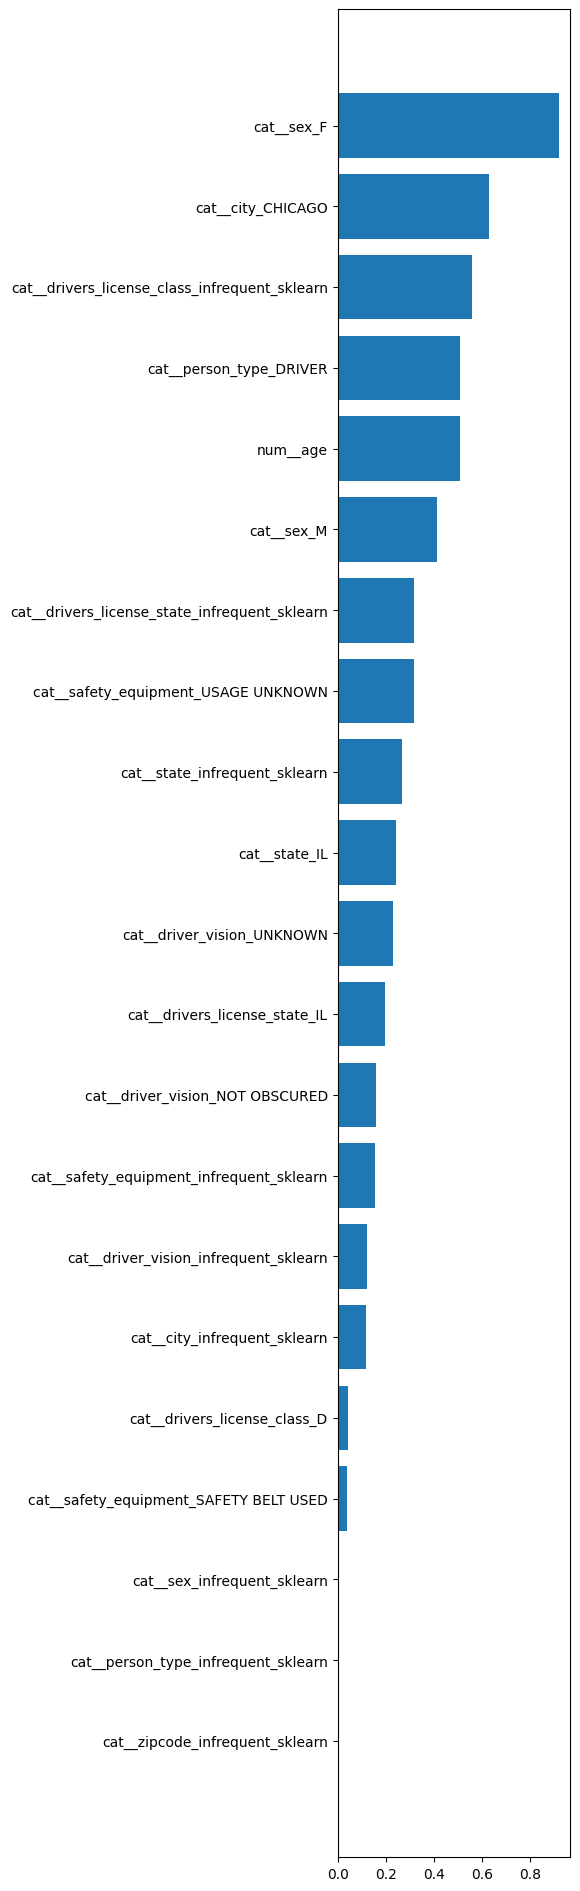

c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is depreca

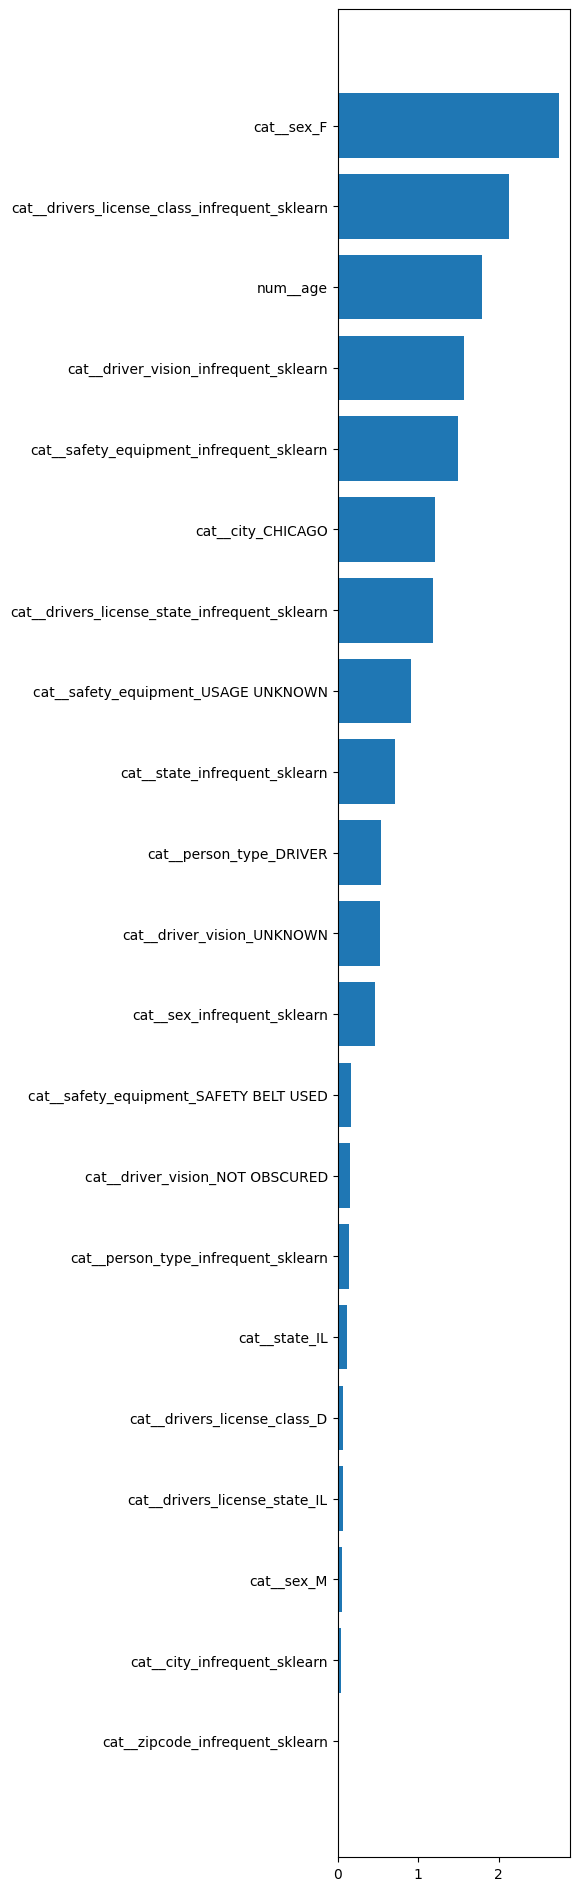

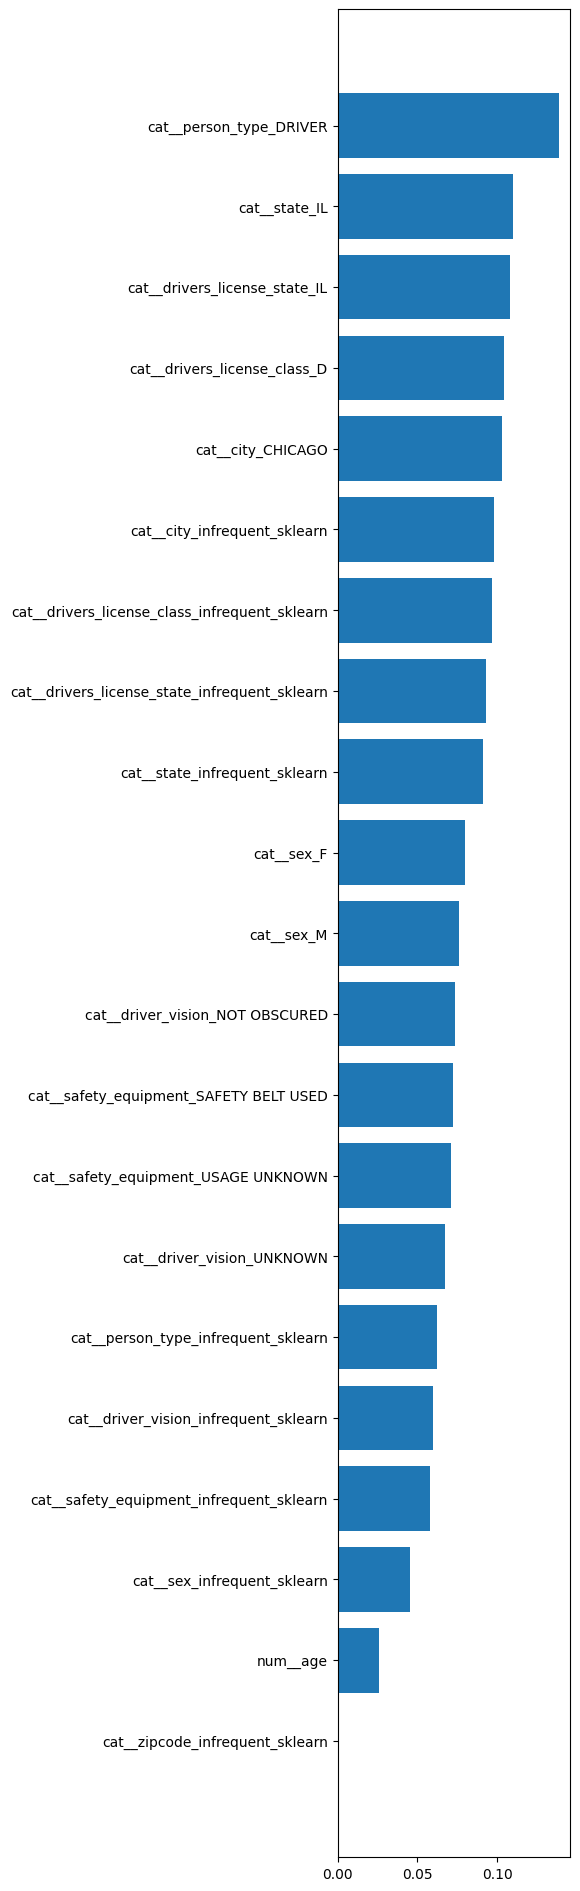

c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.w

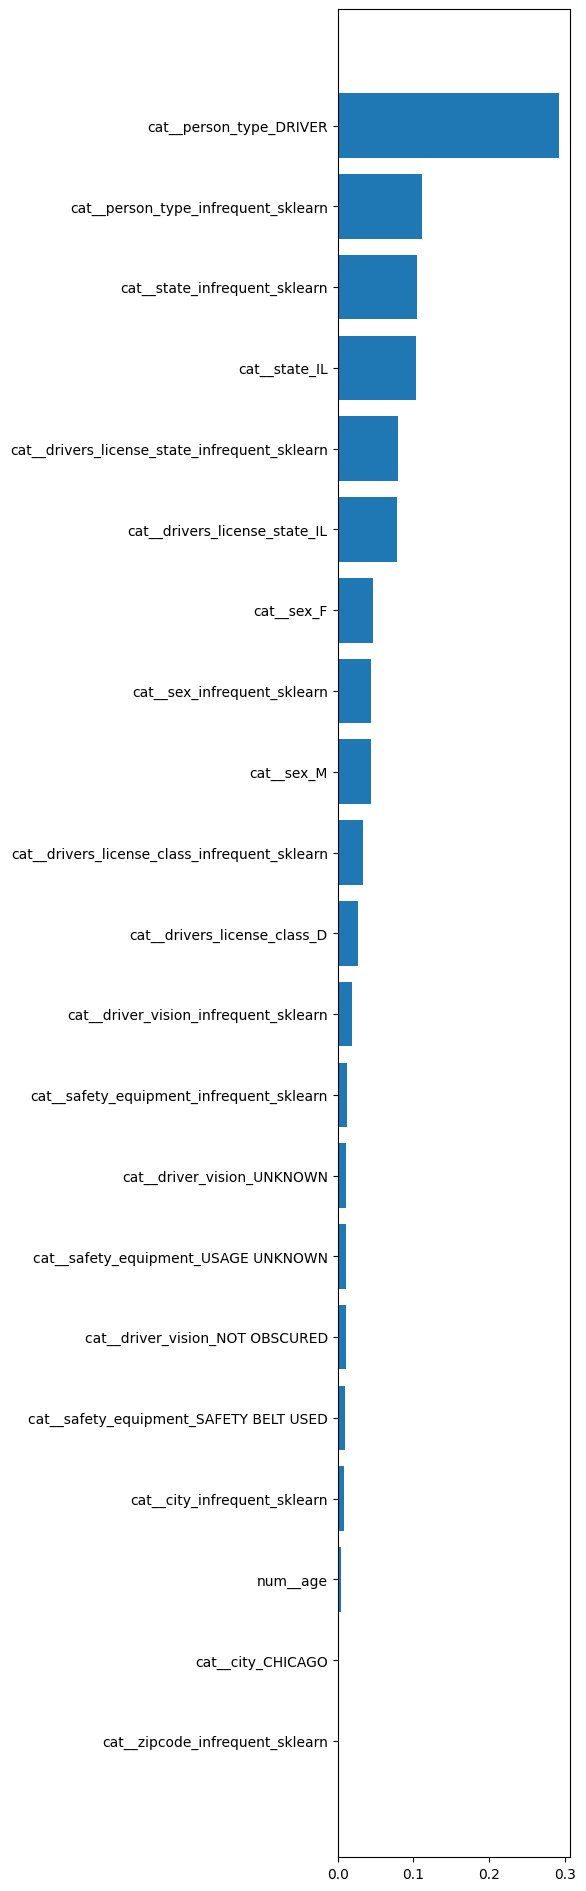

c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


['Logistic (l2)', np.float64(0.925625), 'C = 0.0001', 'cat__sex_F', 1.2462806701660156]
1.2462806701660156 seconds
['Logistic (l1)', np.float64(0.925625), 'C = 0.001', 'cat__sex_F', 9.787163972854614]
9.787163972854614 seconds
['Linear SVM (l2)', np.float64(0.925625), 'C = 0.0001', 'cat__person_type_DRIVER', 0.7866311073303223]
0.7866311073303223 seconds
['Linear SVM (l1)', np.float64(0.925625), 'C = 0.0001', 'cat__person_type_DRIVER', 7.351109266281128]
7.351109266281128 seconds
['Random Forest', np.float64(0.9259999999999999), "{'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 50}", 'cat__sex_F', 19.16351294517517]
19.16351294517517 seconds
['Gradient Boosting Method', np.float64(0.9257499999999999), "{'learning_rate': 0.01, 'n_estimators': 100}", 'num__age', 121.90318083763123]
121.90318083763123 seconds


In [ ]:

start_time = time.time()
b = train_logistic(X_raw, y, reg='l2')
start_time = time.time()
c = train_logistic(X_raw, y, reg='l1')
start_time = time.time()
d = train_svm(X_raw, y, reg='l2')
start_time = time.time()
e = train_svm(X_raw, y, reg='l1')
start_time = time.time()
f = train_rf(X_raw,y)
start_time = time.time()
g = train_gbm(X_raw,y)


print(b)
print("%s seconds" % b[4])
print(c)
print("%s seconds" % c[4])
print(d)
print("%s seconds" % d[4])
print(e)
print("%s seconds" % e[4])
print(f)
print("%s seconds" % f[4])
print(g)
print("%s seconds" % g[4])


<div class="alert alert-info">
    
### Task 4 - Model Results and Discussion [4 pts]
 1. Display a summary table with the following information: train accuracy, val/test accuracy, best parameter, train time, and top predictor.
 2. Justify what model you will use? At what hyperparameter? Why?
 3. Generate the feature importance plot of your chosen best model.
 4. Give insights on the features deemed important by the best model.    
</div>

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 'Run Time']
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = a
df2.loc[1] = b
df2.loc[2] = c
df2.loc[3] = d
df2.loc[4] = e
df2.loc[5] = f
df2.loc[6] = g

df2

<div class="alert alert-block alert-info">
    
### Task 5 - Business Value Articulation [6 pts]

Understanding the analysis results using any of the machine learning models you have implemented above, write guidelines, criteria, or recommendations for triage to be used by emergency personnel for these types of accidents (2-4 sentences or bullet points). [3 pts]
</div>

Your answer here

</div><div class="alert alert-info">

### Task 6 [2 pts]
 1. Predict on the final test set (last 1000 rows of original data) using your best-performing model.
 2. Show and comment on the resulting confusion matrix.
    
</div>